In [1]:
import os
import re
import pickle

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report

In [2]:
import tensorflow as tf

In [3]:
import sys
sys.path.append('../scripts')
from utils import predict, predict_multi_line_text, load_data

sys.path.append('../')
from config import entity_to_acronyms, acronyms_to_entities

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1131)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1131)>


In [4]:
# from importlib import reload

# import utils
# reload(utils)

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense

In [6]:
data_dir = '../data'
model_dir = '../models'

In [7]:
(train_sequences_padded, train_labels), (val_sequences_padded, val_labels), (test_sequences_padded, test_labels), label_to_index, index_to_label = load_data(data_dir)

In [8]:
if train_sequences_padded.shape[1] != train_labels.shape[1]:
    print('Sequence length mismatch')

In [9]:
# Load the tokenizer from file
with open('../data/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

## Model parameters

In [10]:
INPUT_DIM = len(tokenizer.word_index)+1
EMBEDDING_DIM = 64
NUM_CLASSES = len(label_to_index)
MAX_LENGTH = train_sequences_padded.shape[1]

LSTM_UNITS = 64
DENSE_UNITS = 64

DROPOUT_RATE = 0.2
BATCH_SIZE = 32
EPOCHS = 20

## Building Model

In [11]:
from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    _precision = true_positives / (predicted_positives + K.epsilon())
    return _precision

def recall(y_true, y_pred):
    """Compute recall metric"""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def f1_score(y_true, y_pred):
    """Compute f1-score metric"""
    _precision = precision(y_true, y_pred)
    _recall = recall(y_true, y_pred)
    f1_score = 2 * ((_precision * _recall) / (_precision + _recall + K.epsilon()))
    return f1_score

In [13]:
model = tf.keras.models.Sequential([
    
    # Add a word embedding layer to learn the representations of words in the input text
    tf.keras.layers.Embedding(input_dim=INPUT_DIM, output_dim=EMBEDDING_DIM, input_length=MAX_LENGTH),
    
    # Add a Convolutional Neural Network (CNN) layer to capture local patterns in the text
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
    
    # Add a Bidirectional LSTM layer to capture contextual information from both directions
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=LSTM_UNITS, return_sequences=True)),
    
    # Add a TimeDistributed dense layer to apply a dense layer to each time step of the LSTM output
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=DENSE_UNITS, activation='relu')),
    
    # Add a dropout layer to reduce overfitting
    tf.keras.layers.Dropout(rate=DROPOUT_RATE),
    
    # Add a dense layer with softmax activation to output the probabilities of each class
    tf.keras.layers.Dense(units=NUM_CLASSES, activation='softmax'),
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', precision, recall, f1_score])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           446016    
                                                                 
 conv1d (Conv1D)             (None, 100, 32)           6176      
                                                                 
 bidirectional (Bidirectiona  (None, 100, 128)         49664     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 100, 64)          8256      
 ibuted)                                                         
                                                                 
 dropout (Dropout)           (None, 100, 64)           0         
                                                                 
 dense_1 (Dense)             (None, 100, 79)           5

In [15]:
history = model.fit(
    train_sequences_padded, 
    train_labels, 
    epochs=EPOCHS, 
    validation_data=(val_sequences_padded, val_labels)
)

Epoch 1/20


2023-04-09 19:35:59.021692: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


95/95 [==============================] - 5s 33ms/step - loss: 1.0626 - accuracy: 0.8945 - precision: 0.8142 - recall: 0.7213 - f1_score: 0.7581 - val_loss: 0.3808 - val_accuracy: 0.9129 - val_precision: 0.9891 - val_recall: 0.8858 - val_f1_score: 0.9345
Epoch 2/20
95/95 [==============================] - 3s 30ms/step - loss: 0.4002 - accuracy: 0.9063 - precision: 0.9925 - recall: 0.8765 - f1_score: 0.9308 - val_loss: 0.3761 - val_accuracy: 0.9129 - val_precision: 0.9863 - val_recall: 0.8890 - val_f1_score: 0.9351
Epoch 3/20
95/95 [==============================] - 3s 30ms/step - loss: 0.3816 - accuracy: 0.9068 - precision: 0.9930 - recall: 0.8822 - f1_score: 0.9343 - val_loss: 0.3760 - val_accuracy: 0.9127 - val_precision: 0.9816 - val_recall: 0.8955 - val_f1_score: 0.9365
Epoch 4/20
95/95 [==============================] - 3s 30ms/step - loss: 0.3583 - accuracy: 0.9100 - precision: 0.9920 - recall: 0.8910 - f1_score: 0.9387 - val_loss: 0.3712 - val_accuracy: 0.9145 - val_precision: 0.

In [16]:
import matplotlib.pyplot as plt

def plot_graphs(history):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    
    axs[0, 0].plot(history.history['accuracy'])
    axs[0, 0].plot(history.history['val_accuracy'])
    axs[0, 0].set_title('Model Accuracy')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].legend(['train', 'val'], loc='best')
    
    axs[0, 1].plot(history.history['loss'])
    axs[0, 1].plot(history.history['val_loss'])
    axs[0, 1].set_title('Model Loss')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].legend(['train', 'val'], loc='best')
    
    axs[1, 0].plot(history.history['recall'])
    axs[1, 0].plot(history.history['val_recall'])
    axs[1, 0].set_title('Model Recall')
    axs[1, 0].set_ylabel('Recall')
    axs[1, 0].legend(['train', 'val'], loc='best')
    
    axs[1, 1].plot(history.history['f1_score'])
    axs[1, 1].plot(history.history['val_f1_score'])
    axs[1, 1].set_title('Model F1 Score')
    axs[1, 1].set_ylabel('F1 Score')
    axs[1, 1].legend(['train', 'val'], loc='best')
    
    plt.tight_layout()
    plt.show()


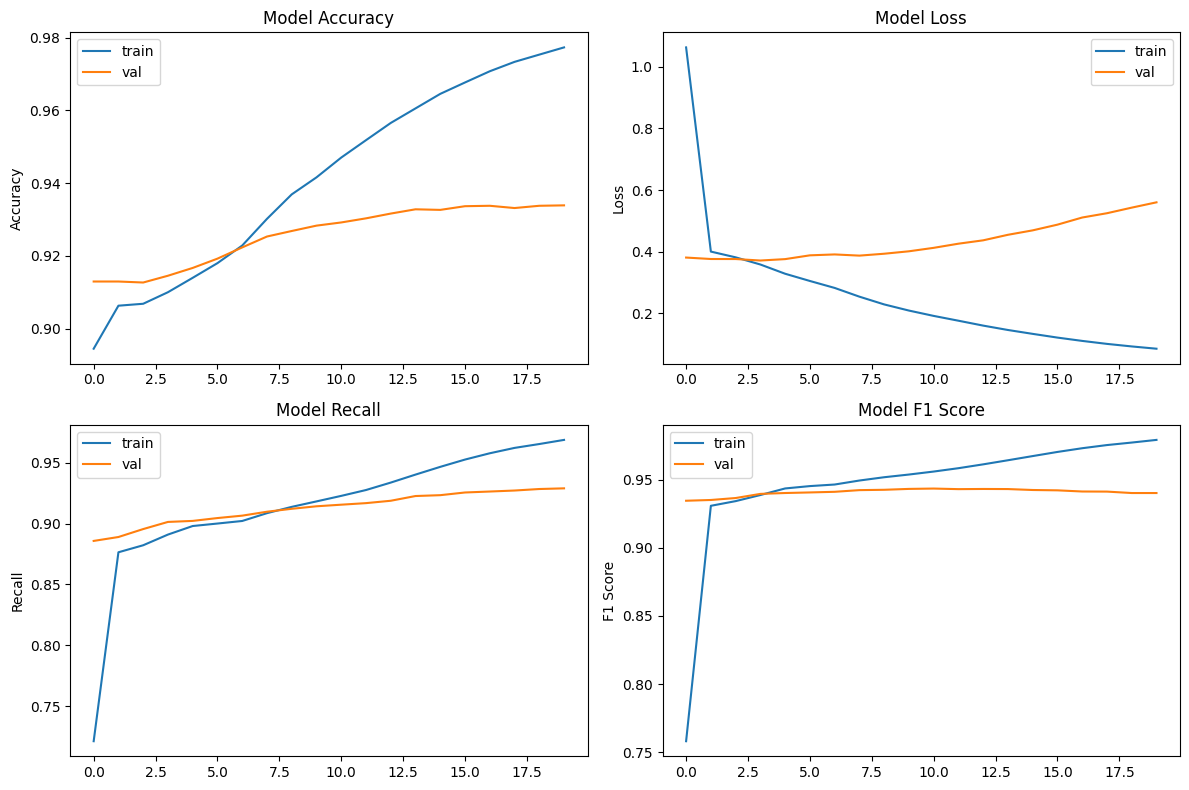

In [17]:
# Plot the training history
plot_graphs(history)

In [18]:
from sklearn.metrics import classification_report

# Get the model predictions
y_pred = model.predict(test_sequences_padded)

# Convert the predictions from one-hot encoded format to the label format
y_pred_labels = np.argmax(y_pred, axis=2)
test_labels_labels = np.argmax(test_labels, axis=2)

# Print the classification report
print(classification_report(test_labels_labels.reshape(-1), y_pred_labels.reshape(-1), zero_division=0))


28/28 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        15
           2       0.28      0.14      0.18        37
           3       0.83      0.83      0.83        36
           4       0.00      0.00      0.00         4
           6       0.40      0.40      0.40       467
           7       0.60      0.47      0.53       100
           8       0.00      0.00      0.00        16
           9       0.00      0.00      0.00        56
          10       0.43      0.51      0.46        97
          11       0.26      0.27      0.26       478
          12       0.54      0.51      0.52       684
          13       0.24      0.17      0.20       236
          14       0.42      0.28      0.33        65
          15       0.21      0.13      0.16        45
          16       0.00      0.00      0.00        16
          17       0.00      0.00      0.00        11
          19       0.16     

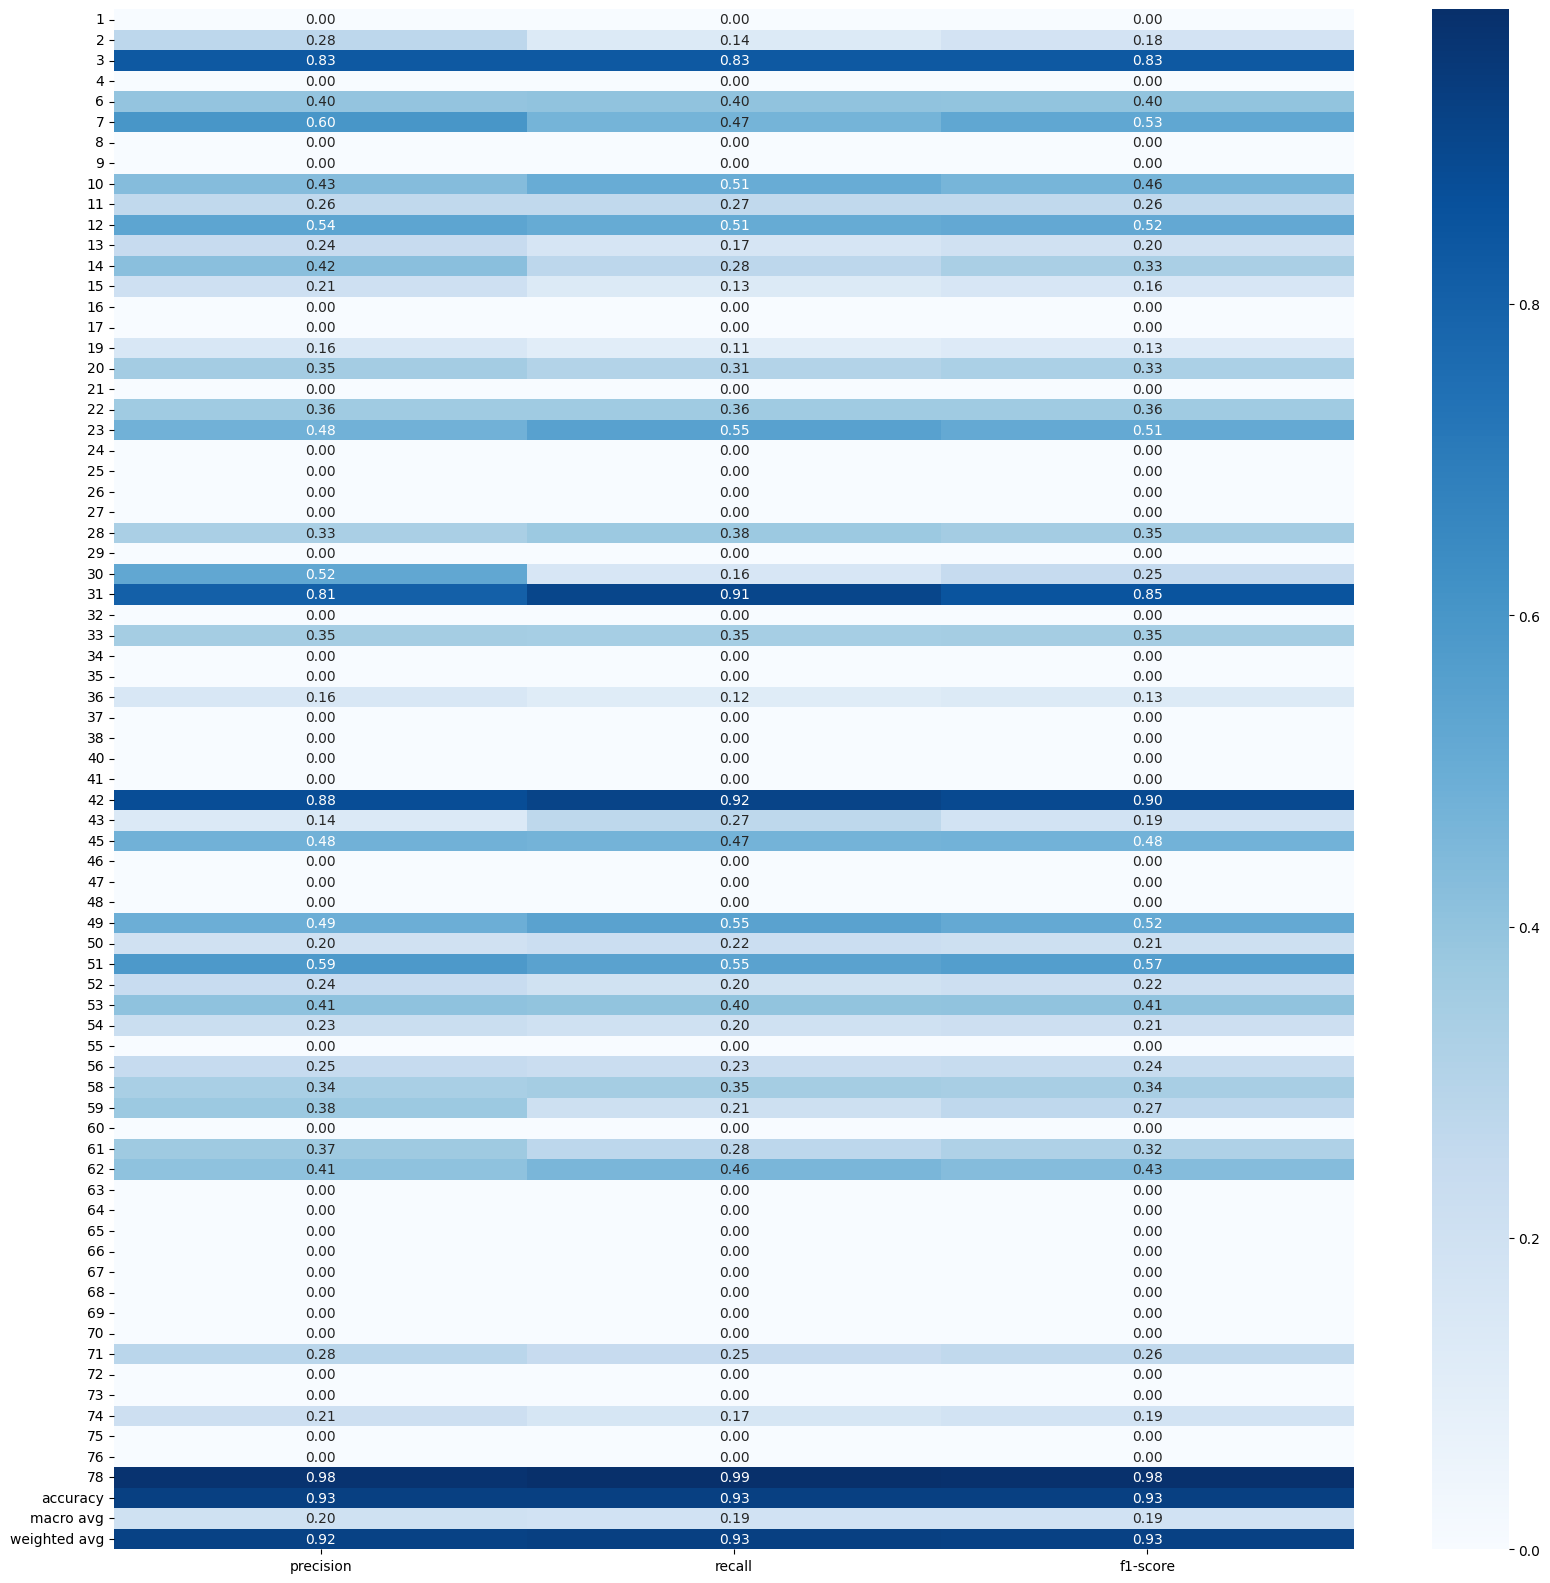

In [20]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

report = classification_report(test_labels_labels.reshape(-1), y_pred_labels.reshape(-1), zero_division=0, output_dict=True)
plt.subplots(figsize=(20, 20))
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='Blues', fmt='.2f')
plt.show()


In the case of NER task, all three metrics - precision, recall, and F1 score - are important.

* Precision measures the proportion of predicted entities that are actually correct. In NER, precision means how many of the predicted named entities are actually true named entities.

* Recall measures the proportion of actual entities that are correctly identified by the model. In NER, recall means how many true named entities are correctly identified by the model.

* F1 score is the harmonic mean of precision and recall. It is a balanced metric that takes into account both precision and recall. F1 score is commonly used in NER evaluation as it takes into account both false positives and false negatives.

A high precision score means that the model is making very few false predictions, while a high recall score means that the model is identifying a high proportion of the true named entities. A high F1 score indicates that the model is both precise and recallful.

In [21]:
model.evaluate(test_sequences_padded, test_labels)

28/28 [==============================] - 0s 10ms/step - loss: 0.6191 - accuracy: 0.9311 - precision: 0.9493 - recall: 0.9272 - f1_score: 0.9381


[0.6190772652626038,
 0.9310932159423828,
 0.9492955207824707,
 0.9271875023841858,
 0.9381080865859985]

## SAVE THE MODEL 

In [22]:
model.save(os.path.join(model_dir, 'model_6.h5'))

## LOAD THE MODEL

In [12]:
# Register the custom metric function
tf.keras.utils.get_custom_objects()[precision.__name__] = precision
tf.keras.utils.get_custom_objects()[recall.__name__] = recall
tf.keras.utils.get_custom_objects()[f1_score.__name__] = f1_score

In [13]:
model_6 = tf.keras.models.load_model(os.path.join(model_dir, 'model_6.h5'))

In [15]:
# Evaluate the model on the test set
test_loss, test_accuracy, test_precision, test_recall, test_f1_score = model_6.evaluate(test_sequences_padded, test_labels)

# Print the test loss and accuracy
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)
print('Test precision:', test_precision)
print('Test recall:', test_recall)
print('Test f1_score:', test_f1_score)


28/28 [==============================] - 1s 9ms/step - loss: 0.6191 - accuracy: 0.9311 - precision: 0.9493 - recall: 0.9272 - f1_score: 0.9381
Test loss: 0.6190772652626038
Test accuracy: 0.9310932159423828
Test precision: 0.9492955207824707
Test recall: 0.9271875023841858
Test f1_score: 0.9381080865859985


In [14]:
predict(
    "The patient underwent an electrophysiologic study with mapping of the accessory pathway, followed by radiofrequency ablation (interruption of the pathway using the heat generated by electromagnetic waves at the tip of an ablation catheter).",
    model_6, 
    index_to_label,
    acronyms_to_entities, 
    MAX_LENGTH
)



2023-04-16 14:01:24.280024: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 365ms/step
Predicted Named Entities:
patient: O
underwent: O
electrophysiologic: Diagnostic_procedure
study: Diagnostic_procedure
mapping: Diagnostic_procedure
accessory: Biological_structure
pathway: Detailed_description
followed: Detailed_description
radiofrequency: Therapeutic_procedure
ablation: O
interruption: O
pathway: O
using: O
heat: O
generated: Therapeutic_procedure
electromagnetic: O
waves: O
tip: O
ablation: O
catheter: O


In [25]:
predict(
    "A 57-year-old man presented to the emergency department with a 2-day history of worsening shortness of breath and chest pain. He reported no recent travel or sick contacts. His medical history was significant for hypertension, dyslipidemia, and type 2 diabetes mellitus. On examination, he was tachycardic and tachypneic, with oxygen saturation of 88% on room air. Chest radiography revealed bilateral opacities consistent with pulmonary edema. The patient was admitted to the intensive care unit for management of acute decompensated heart failure. He was started on intravenous diuretics and inotropic support with dobutamine. Over the next several days, his symptoms improved and he was discharged to home with instructions to follow up with his primary care provider in 1 week.",
    model_6, 
    index_to_label,
    acronyms_to_entities, 
    MAX_LENGTH
)

1/1 [==============================] - 0s 325ms/step
Predicted Named Entities:
57: Age
year: Age
old: Age
man: Sex
presented: Personal_background
emergency: Nonbiological_location
department: Nonbiological_location
2: Nonbiological_location
day: History
history: Sign_symptom
worsening: Sign_symptom
shortness: Biological_structure
breath: Sign_symptom
chest: History
pain: History
reported: History
recent: History
travel: History
sick: History
contacts: History
medical: History
history: History
significant: History
hypertension: History
dyslipidemia: History
type: Sign_symptom
2: Sign_symptom
diabetes: Biological_structure
mellitus: Diagnostic_procedure
examination: Detailed_description
tachycardic: Detailed_description
tachypneic: Detailed_description
oxygen: Biological_structure
saturation: Diagnostic_procedure
88: Lab_value
room: O
air: Biological_structure
chest: Detailed_description
radiography: O
revealed: Nonbiological_location
bilateral: Nonbiological_location
opacities: Nonbiolo

In [26]:
predict_multi_line_text(
    
    "A 57-year-old man presented to the emergency department with a 2-day history of worsening shortness of breath and chest pain. He reported no recent travel or sick contacts. His medical history was significant for hypertension, dyslipidemia, and type 2 diabetes mellitus. On examination, he was tachycardic and tachypneic, with oxygen saturation of 88% on room air. Chest radiography revealed bilateral opacities consistent with pulmonary edema. The patient was admitted to the intensive care unit for management of acute decompensated heart failure. He was started on intravenous diuretics and inotropic support with dobutamine. Over the next several days, his symptoms improved and he was discharged to home with instructions to follow up with his primary care provider in 1 week.",
    model_6, 
    index_to_label,
    acronyms_to_entities, 
    MAX_LENGTH
    
)

1/1 [==============================] - 0s 14ms/step
Predicted Named Entities:
57: Age
year: Age
old: Age
man: Sex
presented: Personal_background
emergency: Nonbiological_location
department: Nonbiological_location
2: Nonbiological_location
day: O
history: Sign_symptom
worsening: Sign_symptom
shortness: Biological_structure
breath: Sign_symptom
chest: O
pain: O




reported: Clinical_event
recent: History
travel: History
sick: O
contacts: O




medical: O
history: O
significant: History
hypertension: History
dyslipidemia: History
type: History
2: History
diabetes: History
mellitus: History




examination: Diagnostic_procedure
tachycardic: Sign_symptom
tachypneic: Diagnostic_procedure
oxygen: Diagnostic_procedure
saturation: Lab_value
88: Detailed_description
room: Detailed_description
air: O




chest: Biological_structure
radiography: Diagnostic_procedure
revealed: Lab_value
bilateral: O
opacities: Biological_structure
consistent: Sign_symptom
pulmonary: O
edema: O




patient: O
admi